In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding, LSTM
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf

# Configuration du style des graphiques
plt.style.use('ggplot')

In [2]:
# Load data
df = pd.read_csv('IMDB Dataset.csv')

# Data inspection

In [3]:
df.head()# Exploration des données

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


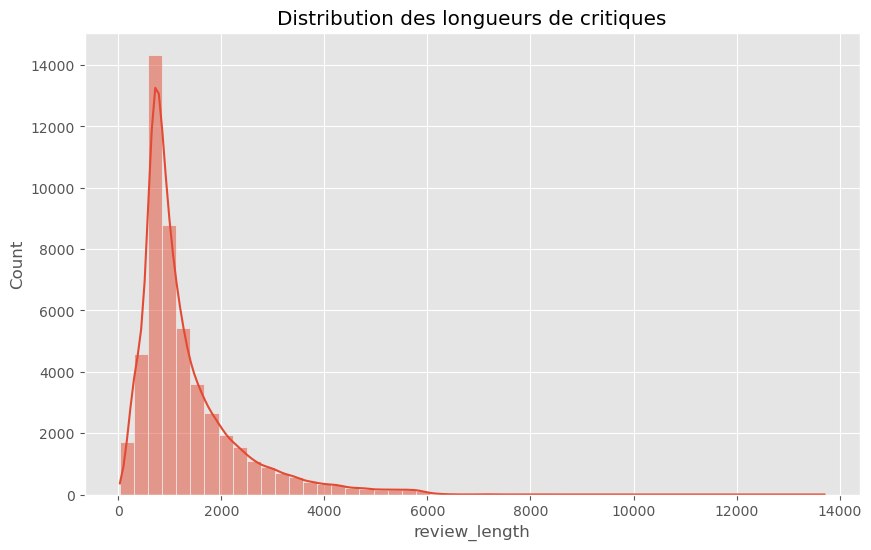

In [5]:
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution des longueurs de critiques')
plt.show()

## 1. L’interprétation et la conclusion que nous pouvons tirer ici est que la majorité des critiques ont une longueur comprise entre 0 et 2000 caractères, avec une chute brutale après 2000 caractères. Cela suggère que la plupart des gens écrivent des critiques courtes.

## 2. C’est un graphique de la distribution des longueurs des critiques. L’axe des x représente la longueur des critiques en caractères et l’axe des y le nombre de critiques. Le graphique est un histogramme rouge avec une courbe lisse superposée. La majorité des critiques ont une longueur comprise entre 0 et 2000 caractères, avec une chute brutale après 2000 caractères.

<Axes: xlabel='sentiment', ylabel='count'>

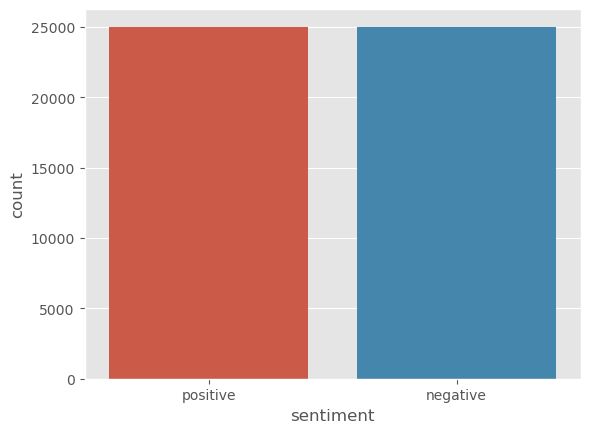

In [6]:
sns.countplot(x='sentiment',data=df)

## 1. L’interprétation et la conclusion que nous pouvons tirer ici est que c’est un graphique à barres montrant le décompte des sentiments positifs et négatifs. Le décompte des sentiments positifs est légèrement supérieur à celui des sentiments négatifs.

## 2. C’est un graphique à barres avec deux barres, une rouge et une bleue. L’axe des x est étiqueté “sentiment” et l’axe des y est étiqueté “décompte”. La barre rouge représente le sentiment positif et la barre bleue représente le sentiment négatif. La barre rouge est légèrement plus haute que la barre bleue. L’axe des y varie de 0 à 25000.


# Data preprocessing(Data cleaning)

In [7]:
df.isnull().sum()

review           0
sentiment        0
review_length    0
dtype: int64

In [8]:
df.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [9]:
df["review"] = df["review"].apply(lambda x: re.sub('<.*?>', '', x))  # Delete  HTML tags
df

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. The filming tec...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642
49997,I am a Catholic taught in parochial elementary...,negative,1280
49998,I'm going to have to disagree with the previou...,negative,1234


In [10]:
df["review"] = df["review"].apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))  # Delete non alphanumeric character
df

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production The filming tec...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there s a family where a little boy ...,negative,748
4,Petter Mattei s Love in the Time of Money is...,positive,1317
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1008
49996,Bad plot bad dialogue bad acting idiotic di...,negative,642
49997,I am a Catholic taught in parochial elementary...,negative,1280
49998,I m going to have to disagree with the previou...,negative,1234


In [11]:
df["review"] = df["review"].str.lower()  # Conversion du texte en minuscules
df

,review,sentiment,review_length
0,one of the other reviewers has mentioned that ...,positive,1761
1,a wonderful little production the filming tec...,positive,998
2,i thought this was a wonderful way to spend ti...,positive,926
3,basically there s a family where a little boy ...,negative,748
4,petter mattei s love in the time of money is...,positive,1317
...,...,...,...
49995,i thought this movie did a down right good job...,positive,1008
49996,bad plot bad dialogue bad acting idiotic di...,negative,642
49997,i am a catholic taught in parochial elementary...,negative,1280
49998,i m going to have to disagree with the previou...,negative,1234


In [12]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))  # Lemmatisation

[nltk_data] Downloading package wordnet to C:\Users\LABO-
[nltk_data]     INFOS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  # Suppression des stop words

[nltk_data] Downloading package stopwords to C:\Users\LABO-
[nltk_data]     INFOS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

df['review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package wordnet to C:\Users\LABO-
[nltk_data]     INFOS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Préparation des données pour l'entraînement du modèle

In [14]:
X = df.review
X

0        one reviewer ha mentioned watching 1 oz episod...
1        wonderful little production filming technique ...
2        thought wa wonderful way spend time hot summer...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movie high art fan expec...
Name: review, Length: 50000, dtype: object

In [15]:
y = df.sentiment
y = np.array(list(map(lambda x : 1 if x=="positive" else 0, y))) #Converting sentiment label to 0 and 1

In [16]:
#Converting sentiment label to 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorisation du texte

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=200)
X_test = pad_sequences(X_test, maxlen=200)

## Create and Train the model 

In [18]:

# Création et entraînement du modèle CNN
model_cnn = Sequential()
model_cnn.add(Embedding(5000, 32, input_length=X_train.shape[1]))
model_cnn.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(250, activation='relu'))
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model_cnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history_cnn = model_cnn.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_test), np.array(y_test)), epochs=5, batch_size=128, verbose=1)





Epoch 1/5


313/313 [==============================] - 28s 77ms/step - loss: 0.3660 - accuracy: 0.8183 - val_loss: 0.2513 - val_accuracy: 0.8945
Epoch 2/5
313/313 [==============================] - 25s 79ms/step - loss: 0.2199 - accuracy: 0.9129 - val_loss: 0.2462 - val_accuracy: 0.8985
Epoch 3/5
313/313 [==============================] - 19s 60ms/step - loss: 0.1765 - accuracy: 0.9331 - val_loss: 0.2710 - val_accuracy: 0.8952
Epoch 4/5
313/313 [==============================] - 19s 60ms/step - loss: 0.1334 - accuracy: 0.9518 - val_loss: 0.2868 - val_accuracy: 0.8868
Epoch 5/5
313/313 [==============================] - 18s 59ms/step - loss: 0.0879 - accuracy: 0.9711 - val_loss: 0.3586 - val_accuracy: 0.8851


## Évaluation du modèle

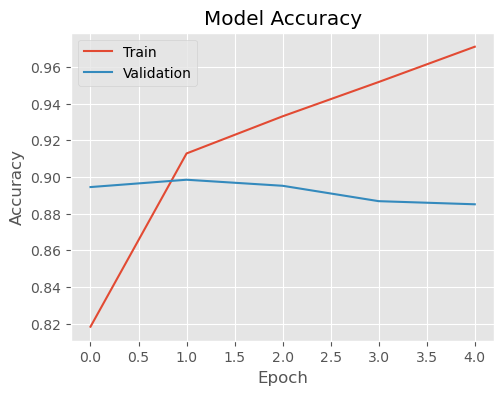

In [19]:
# Tracé de la précision du modèle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

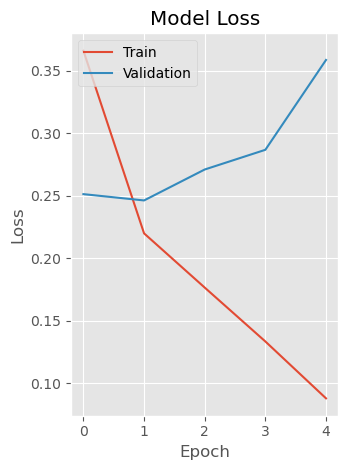

In [20]:
# Tracé de la perte du modèle
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
# Évaluation du modèle
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn = (y_pred_cnn > 0.5)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)
auc_roc = roc_auc_score(y_test, y_pred_cnn)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC: {auc_roc}')


313/313 [==============================] - 2s 6ms/step
Accuracy: 0.8851
Recall: 0.8658463980948601
F1 Score: 0.8836455696202531
AUC-ROC: 0.8852513586926629


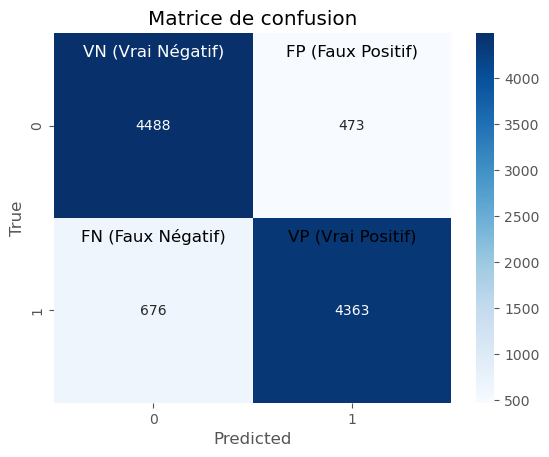

In [22]:

# Calcul de la matrice de confusion
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Affichage de la matrice de confusion avec les indicateurs

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')

# Ajout des indicateurs
plt.text(x=0.5, y=0.1, s='VN (Vrai Négatif)', fontsize=12, ha='center', va='center', color='white')
plt.text(x=1.5, y=0.1, s='FP (Faux Positif)', fontsize=12, ha='center', va='center', color='black')
plt.text(x=0.5, y=1.1, s='FN (Faux Négatif)', fontsize=12, ha='center', va='center', color='black')
plt.text(x=1.5, y=1.1, s='VP (Vrai Positif)', fontsize=12, ha='center', va='center', color='black')

plt.show()

In [23]:
def predict_sentiment(review):
    # Prétraitement de la critique
    review = tokenizer.texts_to_sequences([review])
    review = pad_sequences(review, maxlen=200)

    # Prédiction de la sentiment
    prediction = model_cnn.predict(review)
    sentiment = 'positive' if prediction > 0.5 else 'negative'
    
    return sentiment


In [24]:
reviews = [
    "This movie was a breath of fresh air, with its unique plot and stunning visuals. The performances were top-notch, and I was captivated from start to finish.",
    "I absolutely loved this film! The storyline was compelling and the characters were well-developed. It's a must-see!",
    "A truly enjoyable movie with a great cast and an unexpected twist. I highly recommend it!",
    "This film exceeded my expectations. The acting was superb and the plot kept me on the edge of my seat.",
    "An excellent movie with a well-written script and outstanding performances by the entire cast. I can't wait to see it again!",
    "I was really disappointed by this movie. The plot was predictable and the acting was subpar. I wouldn't recommend it.",
    "This film was a letdown. The storyline was weak and the characters were not relatable at all.",
    "I didn't enjoy this movie. The plot was confusing and the acting was mediocre at best.",
    "Unfortunately, this movie fell short of my expectations. The storyline was lacking and the performances were unconvincing.",
    "This movie was a waste of time. The plot was non-existent and the acting was poor. I wouldn't recommend it to anyone."
]

for review in reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n---")


1/1 [==============================] - 0s 28ms/step
Review: This movie was a breath of fresh air, with its unique plot and stunning visuals. The performances were top-notch, and I was captivated from start to finish.
Predicted Sentiment: positive
---
1/1 [==============================] - 0s 26ms/step
Review: I absolutely loved this film! The storyline was compelling and the characters were well-developed. It's a must-see!
Predicted Sentiment: positive
---
1/1 [==============================] - 0s 26ms/step
Review: A truly enjoyable movie with a great cast and an unexpected twist. I highly recommend it!
Predicted Sentiment: positive
---
1/1 [==============================] - 0s 28ms/step
Review: This film exceeded my expectations. The acting was superb and the plot kept me on the edge of my seat.
Predicted Sentiment: positive
---
1/1 [==============================] - 0s 26ms/step
Review: An excellent movie with a well-written script and outstanding performances by the entire cast. I c

In [26]:
model_cnn.save('sentiment_analysis_model_cnn.keras')


In [27]:
# Sauvegarde du tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Chargement du tokenizer dans l'application Flask
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
